Antes del balanceo: is_fraud
0    792197
1      4465
Name: count, dtype: int64
Después del balanceo: is_fraud
1    787373
0    769466
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:27:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 Matriz de confusión (Test Balanceado):
[[50  3]
 [32 21]]

📋 Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.6098    0.9434    0.7407        53
           1     0.8750    0.3962    0.5455        53

    accuracy                         0.6698       106
   macro avg     0.7424    0.6698    0.6431       106
weighted avg     0.7424    0.6698    0.6431       106

🔥 AUC-ROC: 0.7397650409398363


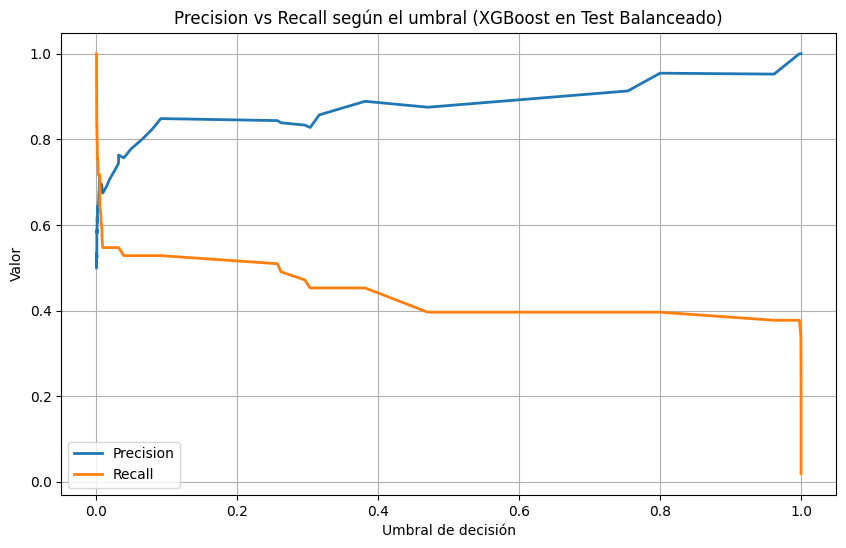

In [44]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from xgboost import XGBClassifier
from sklearn.utils import resample

def load_fraud_data(file_path):
    column_names = ['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
                    'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
                    'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num',
                    'unix_time', 'merch_lat', 'merch_long', 'is_fraud']

    data = []
    with open(file_path, 'r') as f:
        next(f)
        reader = csv.reader(f)
        for row in reader:
            data.append(row[1:])  

    df = pd.DataFrame(data, columns=column_names)

    for col in ['amt', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']:
        df[col] = pd.to_numeric(df[col])

    return df

train = load_fraud_data('/content/fraudTrain.csv')
test = load_fraud_data('/content/fraudTest.csv')

for df in [train, test]:
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
    df['month'] = df['trans_date_trans_time'].dt.month

cols_to_drop = ['cc_num', 'first', 'last', 'street', 'city', 'dob', 'trans_num',
                'unix_time', 'trans_date_trans_time', 'merchant', 'zip']
train.drop(columns=cols_to_drop, inplace=True)
test.drop(columns=cols_to_drop, inplace=True)

label_cols = ['gender', 'category', 'state']
for col in label_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

job_encoding = train.groupby('job')['is_fraud'].mean().to_dict()
train['job'] = train['job'].map(job_encoding)
test['job'] = test['job'].map(job_encoding)
test['job'] = test['job'].fillna(train['is_fraud'].mean())

X_train = train.drop(columns='is_fraud')
y_train = train['is_fraud']
X_test = test.drop(columns='is_fraud')
y_test = test['is_fraud']

print("Antes del balanceo:", y_train.value_counts())

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

print("Después del balanceo:", pd.Series(y_resampled).value_counts())

fraude_ratio = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    scale_pos_weight=fraude_ratio,
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_resampled, y_resampled)

test_fraudes = test[test['is_fraud'] == 1] 
test_no_fraude = test[test['is_fraud'] == 0]  

test_no_fraude_sample = resample(test_no_fraude,
                                 replace=False, 
                                 n_samples=len(test_fraudes),  
                                 random_state=42)

test_balanced = pd.concat([test_fraudes, test_no_fraude_sample])

X_test_balanced = test_balanced.drop(columns='is_fraud')
y_test_balanced = test_balanced['is_fraud']

y_proba_balanced = xgb_model.predict_proba(X_test_balanced)[:, 1]

THRESHOLD = 0.4  
y_pred_balanced = (y_proba_balanced > THRESHOLD).astype(int)

print("Matriz de confusión (Test Balanceado):")
print(confusion_matrix(y_test_balanced, y_pred_balanced))

print("\nReporte de clasificación:")
print(classification_report(y_test_balanced, y_pred_balanced, digits=4))

print("AUC-ROC:", roc_auc_score(y_test_balanced, y_proba_balanced))

precision, recall, thresholds = precision_recall_curve(y_test_balanced, y_proba_balanced)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', linewidth=2)
plt.plot(thresholds, recall[:-1], label='Recall', linewidth=2)
plt.xlabel('Umbral de decisión')
plt.ylabel('Valor')
plt.title('Precision vs Recall según el umbral (XGBoost en Test Balanceado)')
plt.legend()
plt.grid(True)
plt.show()